# Xgboost Model

If you don't want to do hyerparameter tuning ignore installing optuna package

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import optuna

In [4]:
data=pd.read_csv('immo_data_clean.csv')
handy_data=data.copy()

In [5]:
def get_rid_outl(df, list_num_var, percentile):
    """
    INPUT: 
    df: Dataframe
    list_num_var: List of the variables (columns) with outliers that need to be deleted
    percentile: float between 0 and 100: Percentage of the data that will be kept 
    
    OUTPUT:
    DataFrame with the defined amount of data. This means a DataFrame without outliers
    """
    
    perc_dict = {}
    for col in list_num_var: # first, calculate all the percentiles before removing any
        # row, otherwise you will remove more rows than necessary
        value_perc = np.nanpercentile(df[col], percentile)
        value_perc_dict = {col: value_perc}
        perc_dict.update(value_perc_dict)
        
    for var in list_num_var:    
        df = df.loc[(df[var] <= perc_dict[var]) ^ (df[var].isnull())] # include nan values
    
    return df

In [6]:
handy_data.drop(columns=['regionLevel3'], inplace=True)

In [7]:
handy_data.loc[handy_data.yearConstructed == "NO_INFORMATION", "yearConstructed"] = '0'
handy_data['yearConstructed']=handy_data['yearConstructed'].astype(int)
handy_data.loc[handy_data.yearConstructed == 0, "yearConstructed"] = None

In [8]:
handy_data['yearConstructed'] = handy_data['yearConstructed'].fillna(handy_data['yearConstructed'].median())

In [9]:
handy_data.drop(columns=['totalRent',
                 'serviceCharge',
                 'heatingCosts'], inplace=True)

# rename the response variable to rent
handy_data.rename(columns={'rent_incl_hc': 'rent'}, inplace=True)

# remove all rows where living space is 0
handy_data = handy_data[handy_data['livingSpace'] != 0]

# create a new variable for the rent/livingSpace (rent/m2)
handy_data['rent_m2'] = handy_data['rent'] / handy_data['livingSpace']

# get rid of outliers
handy_data = get_rid_outl(handy_data, ['rent_m2'], 99.8)

In [10]:
handy_data.typeOfFlat.replace(np.nan, 'NO_INFORMATION', inplace=True)
handy_data.interiorQuality.replace(np.nan, 'NO_INFORMATION', inplace=True)

In [11]:
# first transform all categorical values into dummies
list_cat_vars = handy_data.select_dtypes(include = ['object']).columns

for var in  list_cat_vars:
    # for each cat add dummy var, drop original column
    handy_data = pd.concat([handy_data.drop(var, axis=1), pd.get_dummies(handy_data[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

handy_data.describe()

,Unnamed: 0,yearConstructed,noParkSpaces,livingSpace,postcode,noRooms,rent,rent_m2,regionLevel1_Bayern,regionLevel1_Berlin,...,lastRefurbish_2012,lastRefurbish_2013,lastRefurbish_2014,lastRefurbish_2015,lastRefurbish_2016,lastRefurbish_2017,lastRefurbish_2018,lastRefurbish_2019,lastRefurbish_2020,lastRefurbish_NO_INFORMATION
count,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,...,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000,216043.000000
mean,133560.294895,1966.829951,0.353383,70.739011,36494.551043,2.567847,774.304525,11.049989,0.079674,0.038631,...,0.009105,0.009628,0.013812,0.018182,0.022778,0.028499,0.051161,0.077887,0.014692,0.682582
std,77625.115921,42.516913,0.546004,26.509316,27943.225308,0.899165,424.253415,4.570212,0.270788,0.192715,...,0.094983,0.097648,0.116711,0.133608,0.149195,0.166394,0.220327,0.267995,0.120315,0.465473
min,0.000000,1000.000000,0.000000,1.000000,852.000000,1.000000,1.000000,0.009455,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66290.000000,1957.000000,0.000000,53.630000,9119.000000,2.000000,474.000000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,133074.000000,1972.000000,0.000000,66.220000,37603.000000,2.500000,645.000000,9.796944,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,200680.000000,1991.000000,1.000000,84.835000,55543.000000,3.000000,955.005000,12.686179,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,268848.000000,2020.000000,4.000000,180.000000,99998.000000,5.000000,2980.000000,44.444444,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
handy_data_new=handy_data[[feat for feat in handy_data.columns.to_list() if feat not in ['Unnamed: 0']] ]

In [ ]:
y = handy_data_new['rent']
X = handy_data_new[[i for i in handy_data_new.columns if i not in ['rent', 'rent_m2']]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  


## I comment the bellow code as I did not have enough resource for optimizing the hyperparameters
### Note: if we want to do a hyperparameter tuning we must split dataset into 3 chunks of train,validation and test and we should choose our hyperparameters of model using validation not test in order to prevent model from over estimating and data leakage.
### At the end for evaluationg the performance of the model we must do a kfold on aggregation of train and test data  in order not to over estimate metrics
### I did not do these two parts as I I did not have enough computation resource but I put the code in bellow

[0]	validation_0-rmse:840.88129
[1]	validation_0-rmse:800.94769
[2]	validation_0-rmse:762.99487
[3]	validation_0-rmse:726.99323
[4]	validation_0-rmse:692.88586
[5]	validation_0-rmse:660.54651
[6]	validation_0-rmse:629.90753
[7]	validation_0-rmse:600.82428
[8]	validation_0-rmse:573.25427
[9]	validation_0-rmse:547.19116
[10]	validation_0-rmse:522.48718
[11]	validation_0-rmse:499.08334
[12]	validation_0-rmse:476.93021
[13]	validation_0-rmse:455.96829
[14]	validation_0-rmse:436.12234
[15]	validation_0-rmse:417.41974
[16]	validation_0-rmse:399.69171
[17]	validation_0-rmse:382.98953
[18]	validation_0-rmse:367.12830
[19]	validation_0-rmse:352.14319
[20]	validation_0-rmse:337.98694
[21]	validation_0-rmse:324.70853
[22]	validation_0-rmse:312.24509
[23]	validation_0-rmse:300.45303
[24]	validation_0-rmse:289.44931
[25]	validation_0-rmse:278.98581
[26]	validation_0-rmse:269.18012
[27]	validation_0-rmse:259.94257
[28]	validation_0-rmse:251.29964
[29]	validation_0-rmse:243.23155
[30]	validation_0-rm

<AxesSubplot:>

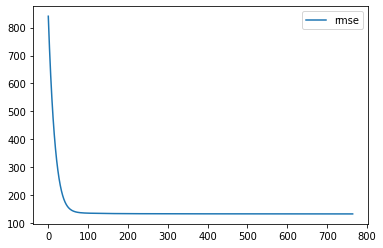

In [16]:
xg_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05,max_depth=30)
X_train, X_test, y_train, y_test
xg_model.fit(X_train, y_train, early_stopping_rounds=5,
             eval_set=[(X_test, y_test)])

max_estimators = len(xg_model.evals_result()['validation_0']['rmse'])
print(max_estimators)
pd.DataFrame(xg_model.evals_result()['validation_0']['rmse'], columns=['rmse']).plot()

In [17]:
from sklearn.metrics import r2_score
y_pred=xg_model.predict(X_test)
r2_score(y_true=y_test, y_pred=y_pred)
r2_score

0.9022735400918777

<AxesSubplot:>

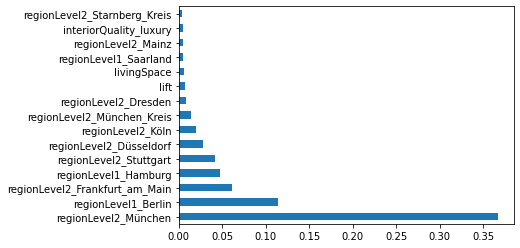

In [23]:
(pd.Series(xg_model.feature_importances_, index=X_train.columns.to_list())
   .nlargest(15)
   .plot(kind='barh'))


The bellow cell is done according no to over estimate the model performance using random chunk of test data at each iteration for evaluation and the mean the result for final

In [ ]:
from xgboost import cv
params={'n_estimators':1000, 'learning_rate':0.05,'max_depth':30}
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  
xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50, early_stopping_rounds=10, metrics=["rmse",'mae'], as_pandas=True, seed=123)

[15:27:19] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:09] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:29:03] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.
